# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.linear_model import Ridge
from matplotlib.colors import Normalize
import networkx as nx
import itertools
from tqdm import tqdm
from scipy.signal import welch
import matplotlib.cm as cm
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
import json

# Baselines

In [2]:
def scale_spectral_radius(W, target_radius=0.95):
    """
    Scales a matrix W so that its largest eigenvalue magnitude = target_radius.
    """
    eigvals = np.linalg.eigvals(W)
    radius = np.max(np.abs(eigvals))
    if radius == 0:
        return W
    return (W / radius) * target_radius

def augment_state_with_squares(x):
    """
    Given state vector x in R^N, return [ x, x^2, 1 ] in R^(2N+1).
    We'll use this for both training and prediction.
    """
    x_sq = x**2
    return np.concatenate([x, x_sq, [1.0]])  # shape: 2N+1

# HHLR [v1]

In [3]:
import numpy as np
from sklearn.linear_model import Ridge
from numpy.linalg import eigvals

# ---------------------------------------------------------------------
# Utility helpers
# ---------------------------------------------------------------------
def scale_spectral_radius(W, desired_radius=0.95):
    """Affine-scale square matrix W so that its spectral radius equals desired_radius."""
    eigs = eigvals(W)
    current_radius = np.max(np.abs(eigs))
    if current_radius == 0:
        raise ValueError("Spectral radius of W is zero.")
    return W * (desired_radius / current_radius)

def augment_state_with_squares(x):
    """[x, x^2, 1]   (same convention as in CycleReservoir3D)."""
    return np.concatenate([x, x**2, [1.0]])

# ---------------------------------------------------------------------
# HH-LR class
# ---------------------------------------------------------------------
class HHLobeReservoir:
    """
    Hemispherically-Hierarchical Lobe Reservoir (HH-LR).

    Topology:
      * 8 anatomical modules  —  L/R × {F, P, T, O}
      * Intra-module: Watts–Strogatz small-world graphs (ring+rewire)
      * Intra-hemisphere inter-lobe: distance-modulated shortcuts
      * Inter-hemisphere (callosal): sparse homotopic bridges
    """

    # --- anatomical bookkeeping -------------------------------------------------
    _LOBES   = ['F', 'P', 'T', 'O']
    _HEMIS   = ['L', 'R']
    # rough 2-D centroids (arbitrary units) for distance computation
    _CENTROIDS = {
        ('L', 'F'): (-1.0,  1.0),
        ('L', 'P'): (-1.0,  0.0),
        ('L', 'T'): (-1.0, -1.0),
        ('L', 'O'): (-1.0, -2.0),
        ('R', 'F'): ( 1.0,  1.0),
        ('R', 'P'): ( 1.0,  0.0),
        ('R', 'T'): ( 1.0, -1.0),
        ('R', 'O'): ( 1.0, -2.0),
    }

    # ------------------------------------------------------------------
    def __init__(self,
                 reservoir_size=800,
                 input_dim=128,
                 spectral_radius=0.9,
                 input_scale=1.0,
                 leaking_rate=1.0,
                 ridge_alpha=1e-6,
                 # small-world / shortcut hyper-parameters
                 k_ring=8,
                 p_rewire_frontal=0.30,
                 p_rewire_other=0.10,
                 P_lat=0.04,
                 sigma=5.0,
                 P_call=0.01,
                 seed=42):
        """
        Parameters
        ----------
        reservoir_size   : total neuron count (split equally across the 8 modules if not divisible)
        input_dim        : dimensionality of input vector u_t  (128 for EEG band-power features)
        leaking_rate     : α in leaky-integrator update
        """
        self.N     = reservoir_size
        self.D_in  = input_dim
        self.rho   = spectral_radius
        self.in_scale   = input_scale
        self.alpha = leaking_rate
        self.ridge_alpha = ridge_alpha
        self.seed  = seed

        # ------------------------------------------------------------------
        # 1) allocate neurons to the 8 modules as evenly as possible
        # ------------------------------------------------------------------
        base = self.N // 8
        counts = [base] * 8
        for i in range(self.N - base*8):
            counts[i] += 1
        self._module_slices = {}
        idx0 = 0
        for h in self._HEMIS:
            for l in self._LOBES:
                n = counts[len(self._module_slices)]
                self._module_slices[(h, l)] = slice(idx0, idx0 + n)
                idx0 += n

        # ------------------------------------------------------------------
        # 2) build adjacency matrix W according to HH-LR rules
        # ------------------------------------------------------------------
        rng = np.random.default_rng(self.seed)
        W = np.zeros((self.N, self.N), dtype=float)

        # 2.1 intra-module small-world wiring
        for (h, l), sl in self._module_slices.items():
            n_mod = sl.stop - sl.start
            k = min(k_ring, n_mod-1)  # guard tiny modules
            p_rewire = p_rewire_frontal if l == 'F' else p_rewire_other
            # ring lattice
            for i_local in range(n_mod):
                for m in range(1, k+1):
                    j_local = (i_local + m) % n_mod
                    i_glob = sl.start + i_local
                    j_glob = sl.start + j_local
                    W[i_glob, j_glob] = rng.standard_normal()
                    W[j_glob, i_glob] = rng.standard_normal()
            # rewire each existing edge with prob p_rewire
            for i_local in range(n_mod):
                for m in range(1, k+1):
                    if rng.random() < p_rewire:
                        # pick a random new target in same module (avoid self-loop)
                        j_local_new = rng.integers(0, n_mod-1)
                        if j_local_new >= i_local:
                            j_local_new += 1
                        i_glob = sl.start + i_local
                        j_glob_new = sl.start + j_local_new
                        # overwrite previous weight (both directions)
                        w_new = rng.standard_normal()
                        W[i_glob, j_glob_new] = w_new
                        W[j_glob_new, i_glob] = rng.standard_normal()

        # 2.2 intra-hemisphere inter-lobe shortcuts (distance-weighted)
        for h in self._HEMIS:
            for l1 in self._LOBES:
                for l2 in self._LOBES:
                    if l1 == l2:
                        continue
                    sl1 = self._module_slices[(h, l1)]
                    sl2 = self._module_slices[(h, l2)]
                    c1 = np.array(self._CENTROIDS[(h, l1)])
                    c2 = np.array(self._CENTROIDS[(h, l2)])
                    dist = np.linalg.norm(c1 - c2)
                    p_edge = P_lat * np.exp(-dist / sigma)
                    for i in range(sl1.start, sl1.stop):
                        mask = rng.random(sl2.stop - sl2.start) < p_edge
                        js = np.nonzero(mask)[0] + sl2.start
                        if js.size:
                            W[i, js] = rng.standard_normal(size=js.size)
                            W[js, i] = rng.standard_normal(size=js.size)

        # 2.3 inter-hemisphere callosal bridges (homotopic)
        for l in self._LOBES:
            sl_L = self._module_slices[('L', l)]
            sl_R = self._module_slices[('R', l)]
            for i in range(sl_L.start, sl_L.stop):
                mask = rng.random(sl_R.stop - sl_R.start) < P_call
                js = np.nonzero(mask)[0] + sl_R.start
                if js.size:
                    W[i, js] = rng.standard_normal(size=js.size)
                    W[js, i] = rng.standard_normal(size=js.size)

        # 2.4 spectral scaling
        W = scale_spectral_radius(W, self.rho)
        self.W = W

        # ------------------------------------------------------------------
        # 3) random input weights
        # ------------------------------------------------------------------
        rng = np.random.default_rng(self.seed + 1)
        self.W_in = (rng.random((self.N, self.D_in)) - 0.5) * 2.0 * self.in_scale

        # readout and state
        self.W_out = None
        self.x = np.zeros(self.N)

    # ------------------------------------------------------------------
    # ESN core methods (same signatures as CycleReservoir3D)
    # ------------------------------------------------------------------
    def reset_state(self):
        self.x = np.zeros(self.N)

    def _update(self, u):
        pre_activation = self.W @ self.x + self.W_in @ u
        x_new = np.tanh(pre_activation)
        self.x = (1.0 - self.alpha) * self.x + self.alpha * x_new

    def collect_states(self, inputs, discard=100):
        """
        Parameters
        ----------
        inputs  : iterable / array of shape (T, input_dim)
        discard : number of initial time-steps to omit from training
        """
        self.reset_state()
        states = []
        for u in inputs:
            self._update(u)
            states.append(self.x.copy())
        return np.array(states[discard:]), np.array(states[:discard])

    def fit_readout(self, train_input, train_target, discard=100):
        """
        Ridge regression read-out; identical augmentation as baseline.
        """
        states_use, _ = self.collect_states(train_input, discard=discard)
        targets_use = train_target[discard:]
        X_aug = np.vstack([augment_state_with_squares(s) for s in states_use])

        reg = Ridge(alpha=self.ridge_alpha, fit_intercept=False)
        reg.fit(X_aug, targets_use)
        self.W_out = reg.coef_

    def predict_sequence(self, inputs):
        """
        Feed-forward prediction (no teacher forcing).  Suitable for classification:
        returns raw linear outputs; apply threshold/sigmoid externally.
        """
        preds = []
        self.reset_state()
        for u in inputs:
            self._update(u)
            preds.append(self.W_out @ augment_state_with_squares(self.x)) # quadratic lift-off
            #preds.append(self.W_out @ self.x)
        return np.array(preds)
    
    def predict_autoregressive(self, initial_input, n_steps):
        preds = []
        current_in = np.array(initial_input)
        for _ in range(n_steps):
            self._update(current_in)
            out = self.W_out @ augment_state_with_squares(self.x)
            preds.append(out)
            current_in = out
        return np.array(preds)

### NRMSE

In [4]:
def evaluate_nrmse(all_preds, test_target, horizons):
    """
    Evaluate model performance over multiple prediction horizons
    for teacher-forced single-step forecasting or autoregressive rollout.
    """
    horizon_nrmse = {}
    for horizon in horizons:
        preds = all_preds[:horizon]
        targets = test_target[:horizon]
        squared_errors = (preds - targets) ** 2
        variance = np.var(targets, axis=0)
        variance[variance == 0] = 1e-8  # avoid divide-by-zero
        nrmse = np.sqrt(np.sum(squared_errors) / (horizon * np.sum(variance)))
        horizon_nrmse[horizon] = nrmse
    return horizon_nrmse

### VPT

In [5]:
def compute_valid_prediction_time(y_true, y_pred, test_time, lyapunov_time, threshold=0.4):
    y_mean = np.mean(y_true, axis=0)
    y_centered = y_true - y_mean
    denom = np.mean(np.sum(y_centered**2, axis=1))

    error = y_true - y_pred
    squared_error = np.sum(error**2, axis=1)
    delta = squared_error / denom

    idx_exceed = np.where(delta > threshold)[0]
    if len(idx_exceed) == 0:
        # never exceeds threshold => set T_VPT to the final time
        T_VPT = test_time[-1]
    else:
        T_VPT = test_time[idx_exceed[0]]

    ratio = T_VPT / lyapunov_time

    return T_VPT, ratio

### ADev

In [6]:
def compute_attractor_deviation(predictions, targets, cube_size=(0.1, 0.1, 0.1)):
    """
    Compute the Attractor Deviation (ADev) metric.

    Parameters:
        predictions (numpy.ndarray): Predicted trajectories of shape (n, 3).
        targets (numpy.ndarray): True trajectories of shape (n, 3).
        cube_size (tuple): Dimensions of the cube (dx, dy, dz).

    Returns:
        float: The ADev metric.
    """
    # Define the cube grid based on the range of the data and cube size
    min_coords = np.min(np.vstack((predictions, targets)), axis=0)
    max_coords = np.max(np.vstack((predictions, targets)), axis=0)

    # Create a grid of cubes
    grid_shape = ((max_coords - min_coords) / cube_size).astype(int) + 1

    # Initialize the cube occupancy arrays
    pred_cubes = np.zeros(grid_shape, dtype=int)
    target_cubes = np.zeros(grid_shape, dtype=int)

    # Map trajectories to cubes
    pred_indices = ((predictions - min_coords) / cube_size).astype(int)
    target_indices = ((targets - min_coords) / cube_size).astype(int)

    # Mark cubes visited by predictions and targets
    for idx in pred_indices:
        pred_cubes[tuple(idx)] = 1
    for idx in target_indices:
        target_cubes[tuple(idx)] = 1

    # Compute the ADev metric
    adev = np.sum(np.abs(pred_cubes - target_cubes))
    return adev

### PSD

In [7]:
def compute_psd(y, dt=0.01):
    z = y[:, 2]  # Extract Z-component
    
    # Compute PSD using Welch’s method
    freqs, psd = welch(z, fs=1/dt, window='hamming', nperseg=len(z))  # Using Hamming window
    
    return freqs, psd

# MIT-BIH Dataset

In [98]:
def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

In [99]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

In [100]:
# Get input signal u(t) from the first channel
u = record.p_signal[:, 0] 
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425],
      shape=(25002,))

In [101]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

In [102]:
fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

In [103]:
emb_dim = 3
# inputs = u_norm
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

In [104]:
data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}") 

Total samples: 25000, train size: 15000, test size: 9999


In [109]:
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    hhlr = HHLobeReservoir(
        reservoir_size=500,
        input_dim=emb_dim,
        spectral_radius=0.0001,
        input_scale=1.5,
        leaking_rate=0.9,
        ridge_alpha=1e-08,
        k_ring=6,
        p_rewire_frontal=0.30,
        p_rewire_other=0.10,
        P_lat=0.04,
        sigma=5.0,
        P_call=0.01,
        seed=seed
    )
    hhlr.fit_readout(train_input, train_target, discard=5000)
    hhlr_preds = hhlr.predict_sequence(test_input)
    hhlr_nrmse = evaluate_nrmse(hhlr_preds, test_target, horizons)
    nrmse_dict['HHLR'].append(hhlr_nrmse)

In [110]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'HHLR':<17}")
print("-" * 140)

for horizon in horizons:
    hhlr_vals = [np.mean(hhlr_nrmse[horizon]) for hhlr_nrmse in nrmse_dict['HHLR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [hhlr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean} ± {std}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
HHLR             
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.2677566717347884 ± 0.006063637930798729
600        0.3155822163726197 ± 0.004610418356072609
1000       0.4394767105225158 ± 0.004610194160673745


# Sunspot Dataset

In [51]:
import pandas as pd
file_path = 'RealWorld/datasets/SN_m_tot_V2.0.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3310,2024,11,2024.873,152.5,20.9,681,0
3311,2024,12,2024.958,154.5,25.6,572,0
3312,2025,1,2025.042,137.0,23.3,670,0
3313,2025,2,2025.122,154.6,23.3,655,0


In [52]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [85]:
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    hhlr = HHLobeReservoir(
        reservoir_size=500,
        input_dim=emb_dim,
        spectral_radius=0.1,
        input_scale=0.000001,
        leaking_rate=0.9,
        ridge_alpha=1e-08,
        k_ring=6,
        p_rewire_frontal=0.30,
        p_rewire_other=0.10,
        P_lat=0.04,
        sigma=5.0,
        P_call=0.01,
        seed=seed
    )
    hhlr.fit_readout(train_input, train_target, discard=100)
    hhlr_preds = hhlr.predict_sequence(test_input)
    hhlr_nrmse = evaluate_nrmse(hhlr_preds, test_target, horizons)
    nrmse_dict['HHLR'].append(hhlr_nrmse)

In [86]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'HHLR':<17}")
print("-" * 140)

for horizon in horizons:
    hhlr_vals = [np.mean(hhlr_nrmse[horizon]) for hhlr_nrmse in nrmse_dict['HHLR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [hhlr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean} ± {std}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
HHLR             
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.2518938299029971 ± 5.0188758236031255e-05
600        0.20408723950118077 ± 3.8554511582339564e-05
1000       0.2025080720350752 ± 2.9866115555249395e-05


# Sante Fe Dataset

In [87]:
import pandas as pd

file_path = 'RealWorld/datasets/santa-fe-time-series-competition-data-set-b-1.0.0/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df

,0,1,2,3
0,76.53,8320,7771,NaN
1,76.53,8117,7774,NaN
2,76.15,7620,7788,NaN
3,75.39,6413,7787,NaN
4,75.51,7518,7767,NaN
...,...,...,...,...
16995,73.57,16021,6498,NaN
16996,73.79,-6957,6547,NaN
16997,74.54,11476,6576,NaN
16998,74.36,15058,6573,NaN


In [88]:
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())

In [89]:
data = df.iloc[:, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 7000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")


Data length: 17000.
Train size: 7000  
Test size: 9997


In [96]:
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    hhlr = HHLobeReservoir(
        reservoir_size=500,
        input_dim=emb_dim,
        spectral_radius=0.1,
        input_scale=0.001,
        leaking_rate=0.9,
        ridge_alpha=1e-08,
        k_ring=6,
        p_rewire_frontal=0.30,
        p_rewire_other=0.10,
        P_lat=0.04,
        sigma=5.0,
        P_call=0.01,
        seed=seed
    )
    hhlr.fit_readout(train_input, train_target, discard=100)
    hhlr_preds = hhlr.predict_sequence(test_input)
    hhlr_nrmse = evaluate_nrmse(hhlr_preds, test_target, horizons)
    nrmse_dict['HHLR'].append(hhlr_nrmse)

In [97]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'HHLR':<17}")
print("-" * 140)

for horizon in horizons:
    hhlr_vals = [np.mean(hhlr_nrmse[horizon]) for hhlr_nrmse in nrmse_dict['HHLR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [hhlr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean} ± {std}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
HHLR             
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.1625942273766201 ± 0.0015864192947001516
600        0.13326051267076544 ± 0.000407011178925061
1000       0.14440468459939237 ± 0.00031377393089875933


In [ ]:
# for seed in seeds:
#     crj = CRJRes3D(
#         reservoir_size=500,
#         edge_weight=0.8,
#         jump=15,
#         spectral_radius=0.99,
#         input_scale=0.2,
#         leaking_rate=0.8,
#         ridge_alpha=1e-6,
#         seed=seed
#     )
#     crj.fit_readout(train_input, train_target, discard=5000)
#     crj_preds = crj.predict(test_input)
#     crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
#     nrmse_dict['CRJ'].append(crj_nrmse)

# for seed in seeds:
#     mci_esn = MCIESN3D(
#         reservoir_size=500,
#         cycle_weight=0.8,
#         connect_weight=0.8,
#         combine_factor=0.1,
#         v1=0.03,
#         v2=0.03,
#         spectral_radius=0.99,
#         leaking_rate=0.8,
#         ridge_alpha=1e-6,
#         seed=seed
#     )
#     mci_esn.fit_readout(train_input, train_target, discard=5000)
#     mci_esn_preds = mci_esn.predict(test_input)
#     mci_esn_nrmse = evaluate_nrmse(mci_esn_preds, test_target, horizons)
#     nrmse_dict['MCI-ESN'].append(mci_esn_nrmse)


# for seed in seeds:
#     deepesn = DeepESN3D(
#         num_layers=5,
#         reservoir_size=100,
#         spectral_radius=0.99,
#         input_scale=0.2,
#         leaking_rate=0.8,
#         ridge_alpha=1e-6,
#         seed=seed
#     )
#     deepesn.fit_readout(train_input, train_target, discard=5000)
#     deepesn_preds = deepesn.predict(test_input)
#     deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, horizons)
#     nrmse_dict['DeepESN'].append(deepesn_nrmse)


In [26]:
for horizon in [1000]:
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]

In [27]:
crj_vals

[np.float64(0.29000843893248435),
 np.float64(0.309148323024945),
 np.float64(0.32659144846892424),
 np.float64(0.3039714851291318),
 np.float64(0.29258113930886226),
 np.float64(0.31024836734397154),
 np.float64(0.2951963586421195),
 np.float64(0.2853331750098682),
 np.float64(0.31924539710353983),
 np.float64(0.30016568182513714),
 np.float64(0.3191322226103948),
 np.float64(0.33379069862031424),
 np.float64(0.3143257694771222),
 np.float64(0.31721888143145544),
 np.float64(0.30552764770563207),
 np.float64(0.3011093344323173),
 np.float64(0.3555299804718019),
 np.float64(0.31279757786746004),
 np.float64(0.3062745634197625),
 np.float64(0.31540614075135104),
 np.float64(0.3073646034931301),
 np.float64(0.32850520523876053),
 np.float64(0.2868286264541298),
 np.float64(0.30146383711230884),
 np.float64(0.31231718734721303),
 np.float64(0.3251354111071609),
 np.float64(0.3295762473780636),
 np.float64(0.30554270928538646),
 np.float64(0.3057524375888075),
 np.float64(0.316919255556912

In [ ]:
nrmse_dict['CRJ']

NameError: name 'nrmse_dict' is not defined

In [21]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'HFR':<17}")
print("-" * 140)


for horizon in horizons:
    hfr_vals = [np.mean(hfr_nrmse[horizon]) for hfr_nrmse in nrmse_dict['HFR']]

    print(f"{horizon:<10}", end=" ")
    for vals in [hfr_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean} ± {std}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
HFR              
--------------------------------------------------------------------------------------------------------------------------------------------
300        nan ± nan         
600        nan ± nan         
1000       nan ± nan         


c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\shrey\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret 

# BCI

In [9]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

data_dir = 'RealWorld/datasets/BCI_Competion4_dataset4/BCI_Competion4_dataset4'

mat_files = [f for f in os.listdir(data_dir) if f.lower().endswith('.mat')]
if not mat_files:
    raise FileNotFoundError(f'No .mat files found in {data_dir}')
mat_path = os.path.join(data_dir, mat_files[0])
print("Loading:", mat_path)

# ─── Load the data ────────────────────────────────────────────────────────
data = sio.loadmat(mat_path)
print("Available keys in .mat file:", data.keys())

Loading: RealWorld/datasets/BCI_Competion4_dataset4/BCI_Competion4_dataset4\sub1_comp.mat
Available keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'train_data', 'test_data', 'train_dg'])


X_train shape:  (400000, 62)    (timepoints × channels)
Y_train shape:  (400000, 5)    (timepoints × fingers)
X_test shape:   (200000, 62)     (timepoints × channels)
Y_test shape:   (200000, 5)     (timepoints × fingers)


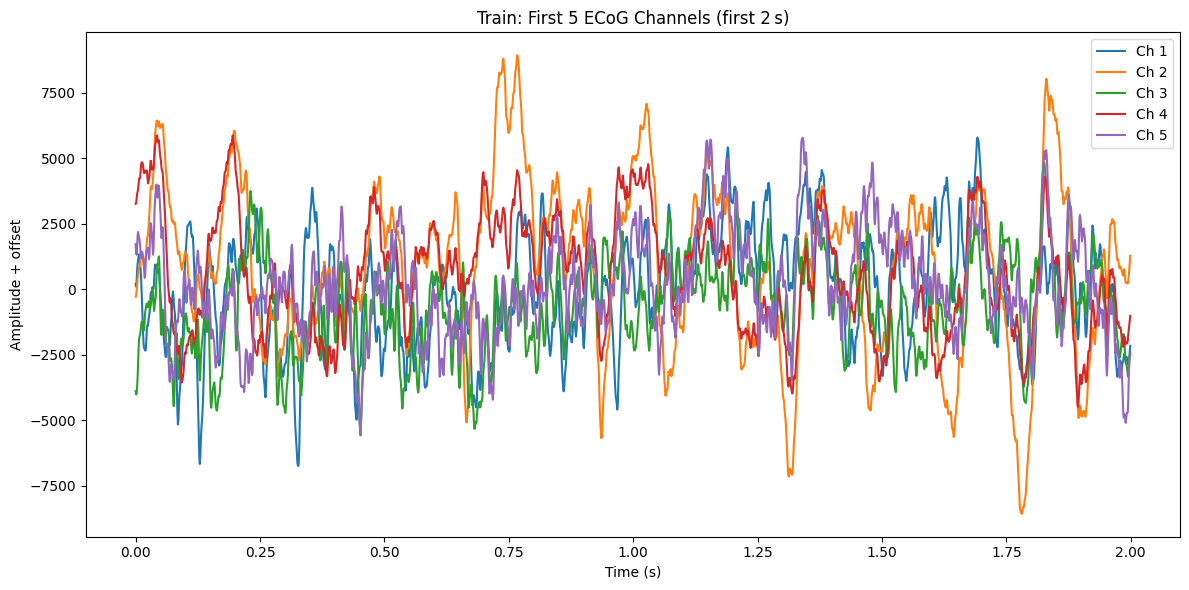

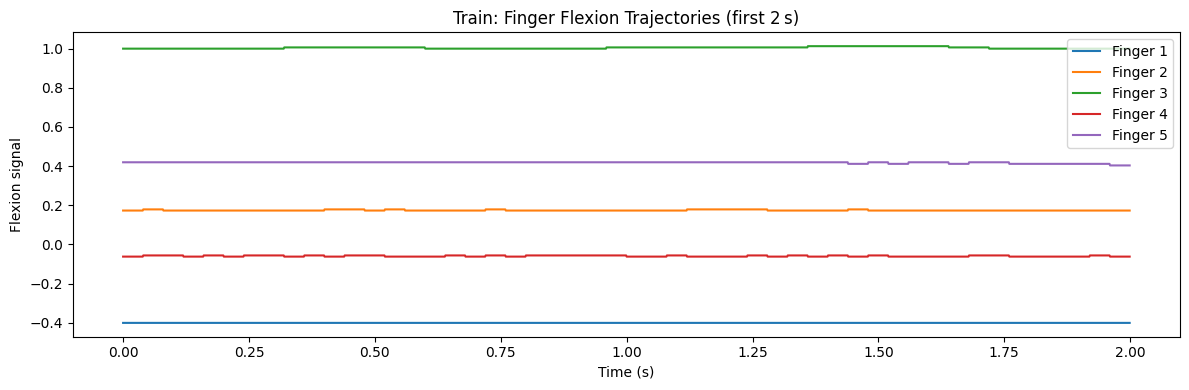

In [10]:
# ─── Load both the “comp” and “testlabels” .mat files ─────────────────────────
comp_path       = os.path.join(data_dir, 'sub1_comp.mat')
testlabels_path = os.path.join(data_dir, 'sub1_testlabels.mat')

comp_data     = sio.loadmat(comp_path)
testlabels    = sio.loadmat(testlabels_path)

# ─── Extract arrays ───────────────────────────────────────────────────────────
# From sub1_comp.mat:
X_train = comp_data['train_data']   # ECoG: (timepoints × channels)
Y_train = comp_data['train_dg']     # Finger flexions: (timepoints × 5)

X_test  = comp_data['test_data']    # ECoG test inputs: (timepoints × channels)

# From sub1_testlabels.mat:
Y_test  = testlabels['test_dg']     # True flexions for X_test: (timepoints × 5)

# ─── Print dimensions ───────────────────────────────────────────────────────
print(f"X_train shape:  {X_train.shape}    (timepoints × channels)")
print(f"Y_train shape:  {Y_train.shape}    (timepoints × fingers)")
print(f"X_test shape:   {X_test.shape}     (timepoints × channels)")
print(f"Y_test shape:   {Y_test.shape}     (timepoints × fingers)")

# ─── Time vector ─────────────────────────────────────────────────────────────
fs = 1000.0
t_train = np.arange(X_train.shape[0]) / fs
t_test  = np.arange(X_test.shape[0])  / fs

# ─── Plot first 5 channels of TRAINING ECoG (first 2 s) ────────────────────
plt.figure(figsize=(12,6))
for ch in range(min(5, X_train.shape[1])):
    plt.plot(t_train[:2000], X_train[:2000, ch] + ch*200, label=f'Ch {ch+1}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude + offset')
plt.title('Train: First 5 ECoG Channels (first 2 s)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# ─── Plot TRAINING finger flexions (first 2 s) ─────────────────────────────
plt.figure(figsize=(12,4))
for f in range(Y_train.shape[1]):
    plt.plot(t_train[:2000], Y_train[:2000, f], label=f'Finger {f+1}')
plt.xlabel('Time (s)')
plt.ylabel('Flexion signal')
plt.title('Train: Finger Flexion Trajectories (first 2 s)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1025)

for seed in seeds:
    hhlr = HHLobeReservoir(
        reservoir_size=500,
        input_dim=emb_dim,
        spectral_radius=0.1,
        input_scale=0.001,
        leaking_rate=0.9,
        ridge_alpha=1e-08,
        k_ring=6,
        p_rewire_frontal=0.30,
        p_rewire_other=0.10,
        P_lat=0.04,
        sigma=5.0,
        P_call=0.01,
        seed=seed
    )
    hhlr.fit_readout(X_train, Y_train, discard=100)
    hhlr_preds = hhlr.predict_sequence(Y_test)
    hhlr_nrmse = evaluate_nrmse(hhlr_preds, test_target, horizons)
    nrmse_dict['HHLR'].append(hhlr_nrmse)